# ICDSS Mini Challenge 2020

"Toxic Comment Classification"

Aim: To classify Wikipedia comments, and detect different types of toxicity:
* toxic
* severe_toxic
* obscene
* threat
* insult
* identity_hate

Given: train.csv and test_cleaned.csv 


In [24]:
import pandas as pd
import numpy as np
from numpy import zeros
import reader
import matplotlib.pyplot as plt
%matplotlib inline

import re
import itertools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

In [80]:
# use reader.py to split the comments and labels and get train and test set
x_train, y_train, x_test, y_test = reader.get_comments()

# x_train = comments for training
# y_train = ground truth labels for trainset
# x_test = test set
# y_test = grond truth labels for test set

# init list for use later
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [7]:
# explore dataset
x_train.head()
y_train.head()
y_train.describe()
y_train.hist
x_test.describe()

# no empty comments / labels 
x_train.isnull().sum()
y_train.isnull().sum()
y_test.isnull().sum()
x_test.isnull().sum()

0

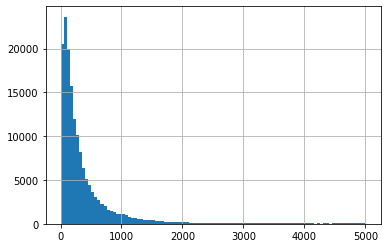

In [8]:
# range of lengths of comments 
x_train.str.len().hist(bins = 100)

# longest and shortest comments
#print(min(x_train, key=len)) 6 words
#print(max(x_train, key=len)) 5000 words

In [9]:
# demonstrate class imbalance
for labels in list_classes:
    print(y_train.groupby(labels).size())
    print('poportion positive: {}%'. \
          format(round(y_train.groupby(labels).size()[1]/y_train.groupby(labels).size()[0]*100)))

toxic
0    144277
1     15294
dtype: int64
poportion positive: 11.0%
severe_toxic
0    157976
1      1595
dtype: int64
poportion positive: 1.0%
obscene
0    151122
1      8449
dtype: int64
poportion positive: 6.0%
threat
0    159093
1       478
dtype: int64
poportion positive: 0.0%
insult
0    151694
1      7877
dtype: int64
poportion positive: 5.0%
identity_hate
0    158166
1      1405
dtype: int64
poportion positive: 1.0%


## Few insights from the dataset:

1. train set sample number = 159,571, test set, n = 63,978
2. 6 labels - can have more than one label for each comment (ie. row 1017)
3. majority of labels are 0 - given low means
4. toxic, obscene and insult labels are top 3 most common 
5. presence of class imbalance as threat & identity_hate is least frequent and 10x less 
6. no empty columns 
7. comments length range from 6 words to 5000 words. majority (80%) < 500 words

In [14]:
# Feature engineering - clean up dataset
# 1. remove http://......
# 2. set everything to lowercase
# 3. remove contractions and apostrophe's
# 4. remove repeated characters, ie. looooong = long

len(x_train[x_train.str.contains("http://")]) # 4426 comments with urls

def remove_urls(x):
    return re.sub(r'http\S+','_URL_ ', x) 

def lowercase(x):
    return x.lower()

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def standardize(x):
    return ''.join(''.join(s)[:2] for _, s in itertools.groupby(x))

x_train = x_train.apply(remove_urls)
x_train = x_train.apply(lowercase)
x_train = x_train.apply(decontracted)
x_train = x_train.apply(standardize)

x_test = x_test.apply(remove_urls)
x_test = x_test.apply(lowercase)
x_test = x_test.apply(decontracted)
x_test = x_test.apply(standardize)

len(x_train[x_train.str.contains("http://")]) # 0 comments with urls



1

In [30]:
y_train = y_train.values
y_test = y_test.values

In [20]:
# using keras tokenizer 

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

AttributeError: 'numpy.ndarray' object has no attribute 'lower'

In [25]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [39]:
# init keras RNN model

deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(60, activation='sigmoid')(LSTM_Layer1)
dense_layer_2 = Dense(30, activation='sigmoid')(dense_layer_1)
dense_layer_3 = Dense(6, activation='sigmoid')(dense_layer_2)

model = Model(inputs=deep_inputs, outputs=dense_layer_3)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [40]:
print(model.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 200, 100)          19212000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_27 (Dense)             (None, 60)                7740      
_________________________________________________________________
dense_28 (Dense)             (None, 30)                1830      
_________________________________________________________________
dense_29 (Dense)             (None, 6)                 186       
Total params: 19,339,004
Trainable params: 127,004
Non-trainable params: 19,212,000
_________________________________________

In [41]:
history = model.fit(x_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
998/998 [==============================] - 354s 354ms/step - loss: 0.1652 - acc: 0.8271 - val_loss: 0.1410 - val_acc: 0.9941
Epoch 2/5
998/998 [==============================] - 349s 350ms/step - loss: 0.1412 - acc: 0.9942 - val_loss: 0.1409 - val_acc: 0.9941
Epoch 3/5
998/998 [==============================] - 351s 352ms/step - loss: 0.1412 - acc: 0.9942 - val_loss: 0.1410 - val_acc: 0.9941
Epoch 4/5
998/998 [==============================] - 336s 336ms/step - loss: 0.1412 - acc: 0.9942 - val_loss: 0.1409 - val_acc: 0.9941
Epoch 5/5
998/998 [==============================] - 336s 337ms/step - loss: 0.1412 - acc: 0.9942 - val_loss: 0.1409 - val_acc: 0.9941


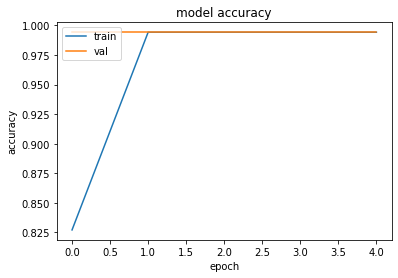

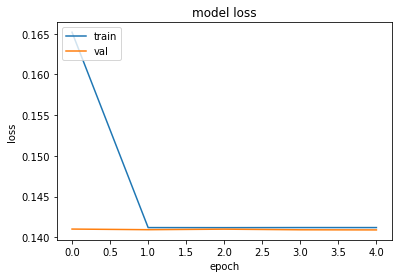

In [44]:
# plot loss and model accuracy over epoch, for train and validation set

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [ ]:
# tune model
# nb. wasn't able to work on this given the insufficient amount of time to work on the project

In [43]:
# evaluation metrics. check if performance equal among classes

model.evaluate(x=x_test, y=y_test)

2000/2000 [==============================] - 144s 72ms/step - loss: 0.1440 - acc: 0.9976


[0.14403760433197021, 0.9976085424423218]

# final comments

Trained a recurrent neural network using forward feed to classify text into 6 types of online toxicity. This work initially started out with exploratory analysis on the training set and labels. Subsequently, a series of cleaning and feature engineering was carried out on the dataset. The train set was then tokenized and word embedding was carried out. A feed forward training of a 6 layer neural network incoporating a LSTM layer was done over 5 epochs, with a loss of 0.14 and accuracy of 0.994. These metrics was similarly found on the test set.

Things that I would want to do to improve:

- Feature engineering: additionally remove or correct for slangs ie. GF = girlfriend
- Do some hyperparameter tuning, search space 
- Compare with other models, ie. linear regression, random forest, bayes 
- check if class imbalance plays a big role, by equalizing number of samples from each label
- concern of overfitting of model on training set, and would like to validate on other samples 